# weather


✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Vestari_Joekulsa_Weather_all_groups_Spearman_NAaware_English.png

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Virkisa_Weather_all_groups_Spearman_NAaware_English.png



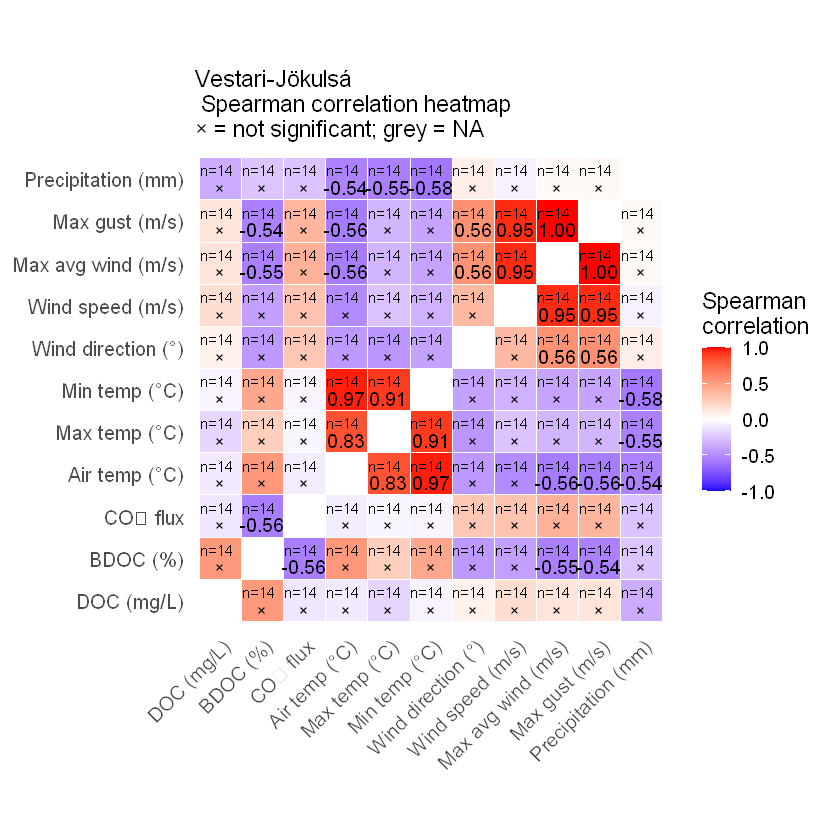

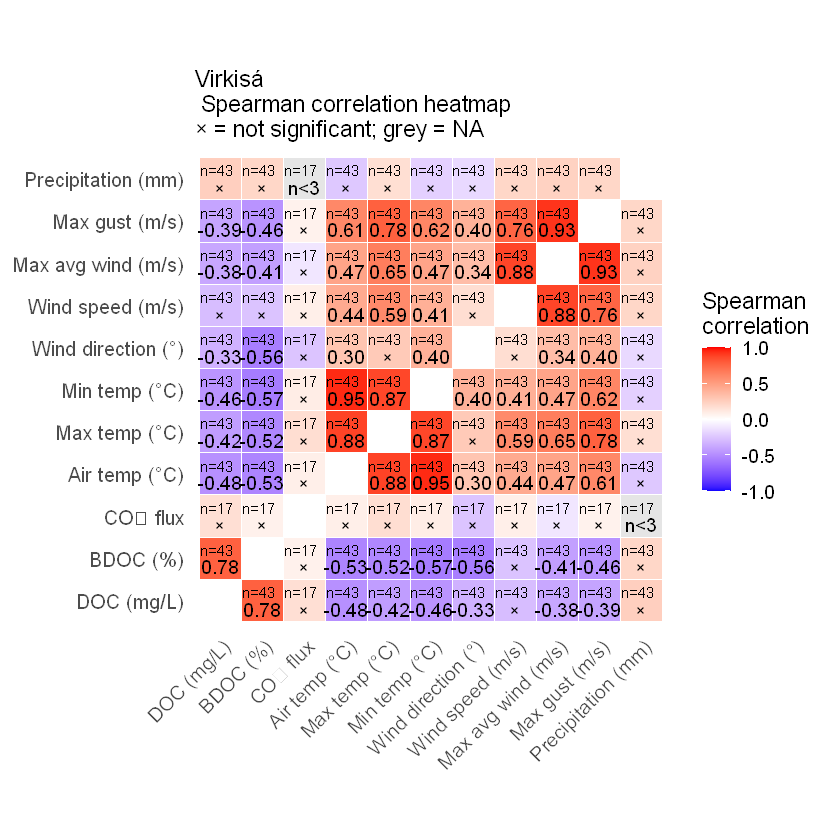

In [70]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(Hmisc)
  library(reshape2); library(ggplot2); library(tidyr); library(tools)
})

# ========= 🔧 EDIT AREA =========
# Variablen & Labels
vars_keep <- c(
  "average_DOC_sample", "BDOC_pct", "CO2_Flux",
  "Air_temp", "Max_temp", "Min_temp",
  "Wind_direction_deg", "Wind_speed_mpers",
  "Max_av_wind_speed_mpers", "Max_wind_gust_mpers",
  "Precipitation_in_past_hour_mm"
)

rename_map <- c(
  average_DOC_sample            = "DOC (mg/L)",
  BDOC_pct                      = "BDOC (%)",
  CO2_Flux                      = "CO₂ flux",
  Air_temp                      = "Air temp (°C)",
  Max_temp                      = "Max temp (°C)",
  Min_temp                      = "Min temp (°C)",
  Wind_direction_deg            = "Wind direction (°)",
  Wind_speed_mpers              = "Wind speed (m/s)",
  Max_av_wind_speed_mpers       = "Max avg wind (m/s)",
  Max_wind_gust_mpers           = "Max gust (m/s)",
  Precipitation_in_past_hour_mm = "Precipitation (mm)"
)

# Korrelationstyp & Gruppenfilter
corr_type    <- "spearman"   # oder "spearman"
group_filter <- "all"       # "all" = alle Gruppen; 1 = nur group_nr==1; 2 = nur group_nr==2; etc.

# Plot-Feintuning (anpassbar)
label_size_main <- 4.0      # Größe der Hauptlabels (Werte/×/n<3)
label_fontface  <- "plain"  # "plain" oder "bold"
label_vjust     <- 1.05     # vertikale Lage der Hauptlabels (>1 = tiefer)
n_size          <- 3.2      # Größe der kleinen "n=..."-Labels
nudge_x         <- 0.38     # Position "n=..." rechts unten
nudge_y         <- 0.38
base_font_size  <- 14       # Grundschrift
axis_text_size  <- 12       # Achsentext
# ===================================

# 📁 File
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(file_path)

# 🔎 Variablenuniversum
carbon_vars  <- c("average_DOC_sample", "BDOC_pct", "CO2_Flux")
weather_vars <- c("Air_temp","Max_temp","Min_temp",
                  "Wind_direction_deg","Wind_speed_mpers",
                  "Max_av_wind_speed_mpers","Max_wind_gust_mpers",
                  "Precipitation_in_past_hour_mm")
vars_all <- c(carbon_vars, weather_vars)

# ✅ Gruppen-Filter anwenden
if (!identical(group_filter, "all")) {
  df <- df %>% filter(group_nr == group_filter)
}

# 📂 Output
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

# 🧰 Plot-Funktion (mit n-Overlay & NA-Handling)
make_plot <- function(river_id, pretty_title) {

  df_river <- df %>% filter(river_name == river_id)

  # nur existierende numerische Spalten
  df_sel0 <- df_river %>%
    select(any_of(vars_all)) %>%
    select(where(is.numeric))

  # Reihenfolge aus vars_keep respektieren
  keep_final <- intersect(vars_keep, names(df_sel0))
  df_sel <- if (length(keep_final) >= 2) df_sel0 %>% select(all_of(keep_final)) else df_sel0

  # Zeilen/Spalten filtern
  df_sel <- df_sel %>%
    filter(rowSums(is.na(.)) < ncol(.)) %>%
    select(where(function(x) {
      v <- x[!is.na(x)]
      length(v) >= 3 && sd(v) != 0
    }))

  if (ncol(df_sel) < 2) stop("Not enough valid variables after filtering.")

  # 🔬 Correlation (rcorr liefert r, P, n)
  co <- rcorr(as.matrix(df_sel), type = corr_type)

  # Wichtig: NA NICHT entfernen -> na.rm = FALSE
  r_df <- reshape2::melt(co$r, na.rm = FALSE)
  p_df <- reshape2::melt(co$P, na.rm = FALSE)
  n_df <- reshape2::melt(co$n, na.rm = FALSE)
  colnames(r_df) <- c("Var1","Var2","Correlation")
  colnames(p_df) <- c("Var1","Var2","Pvalue")
  colnames(n_df) <- c("Var1","Var2","Npair")

  plot_df <- r_df %>%
    left_join(p_df, by = c("Var1","Var2")) %>%
    left_join(n_df, by = c("Var1","Var2")) %>%
    filter(as.character(Var1) != as.character(Var2))

  # Labels mappen
  label_map <- setNames(names(df_sel), names(df_sel))
  label_map[names(rename_map)] <- rename_map[names(rename_map) %in% names(label_map)]

  plot_df <- plot_df %>%
    mutate(
      Var1_lab = dplyr::recode(as.character(Var1), !!!label_map, .default = as.character(Var1)),
      Var2_lab = dplyr::recode(as.character(Var2), !!!label_map, .default = as.character(Var2)),
      Significant = Pvalue < 0.05,
      Label = dplyr::case_when(
        is.na(Correlation) ~ "n<3",
        Significant        ~ sprintf("%.2f", Correlation),
        TRUE               ~ "\u00D7"
      ),
      Nlab = ifelse(is.na(Npair), "", paste0("n=", Npair))
    )

  # Achsenreihenfolge = Reihenfolge in df_sel (per Label)
  axis_order_lab <- unname(label_map[colnames(df_sel)])
  plot_df$Var1_lab <- factor(plot_df$Var1_lab, levels = axis_order_lab)
  plot_df$Var2_lab <- factor(plot_df$Var2_lab, levels = axis_order_lab)

  # 📊 Plot (mit einstellbarer Labelgröße/-position)
  leg_name    <- paste(toTitleCase(corr_type), "\ncorrelation")
  group_label <- ifelse(identical(group_filter, "all"),
                        "all groups",
                        paste0("group_nr=", group_filter))

  p <- ggplot(plot_df, aes(Var1_lab, Var2_lab, fill = Correlation)) +
    geom_tile(color = "white") +
    # Hauptlabel (Korrelation/×/n<3)
    geom_text(aes(label = Label),
              size = label_size_main, fontface = label_fontface, vjust = label_vjust) +
    # kleine n-Angabe unten rechts
    geom_text(aes(label = Nlab),
              size = n_size, hjust = 1.1, vjust = 1.1,
              nudge_x = nudge_x, nudge_y = nudge_y) +
    scale_fill_gradient2(
      low = "blue", mid = "white", high = "red", midpoint = 0,
      limits = c(-1, 1), name = leg_name, na.value = "grey90"
    ) +
    coord_fixed() +
    theme_minimal(base_size = base_font_size) +
    theme(
      axis.text.x = element_text(size = axis_text_size, angle = 45, vjust = 1, hjust = 1),
      axis.text.y = element_text(size = axis_text_size),
      axis.title  = element_blank(),
      panel.grid  = element_blank(),
      plot.title  = element_text(size = base_font_size, face = "plain")
    ) +
    labs(title = paste0(pretty_title, "\n ", toTitleCase(corr_type),
                        " correlation heatmap \n× = not significant; grey = NA"))

  # 💾 Save – Typ & Gruppe im Namen
  outfile <- file.path(
    out_dir,
    paste0("Heatmap_", river_id, "_Weather_",
           gsub("[ =]", "_", group_label), "_",
           toTitleCase(corr_type), "_NAaware_English.png")
  )
  ggsave(outfile, plot = p, width = 10, height = 10, dpi = 300)

  message("✅ Saved: ", outfile)
  print(p)
}

# 🚀 Run for both rivers
make_plot("Vestari_Joekulsa", "Vestari-Jökulsá")
make_plot("Virkisa",         "Virkisá")


# environment 

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Vestari_Joekulsa_Env_all_groups_Spearman_NAaware_Signif_English.png

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Virkisa_Env_all_groups_Spearman_NAaware_Signif_English.png



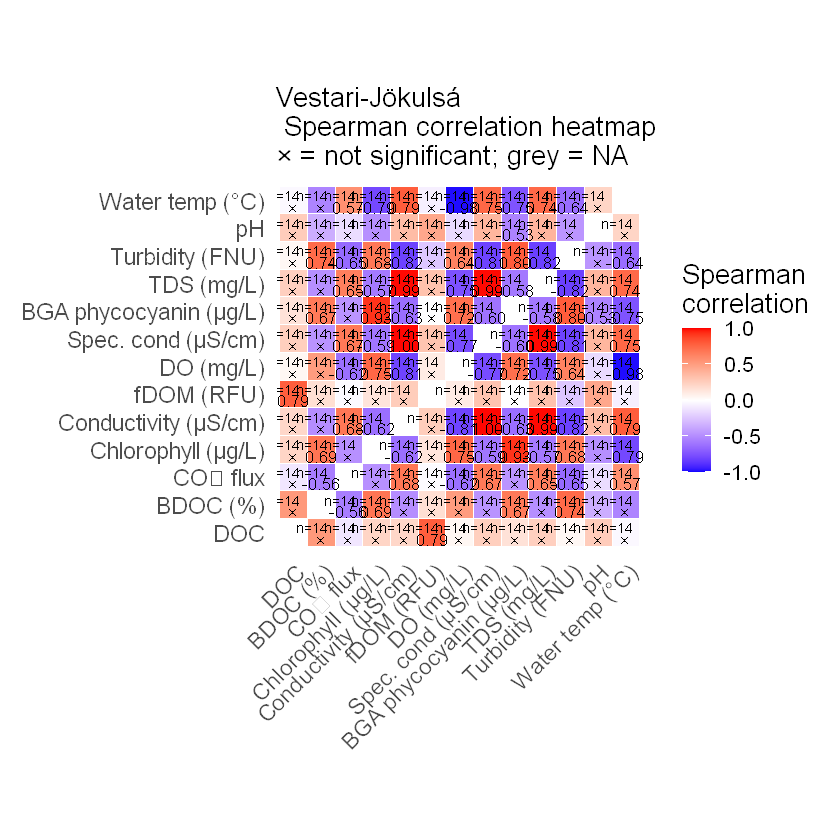

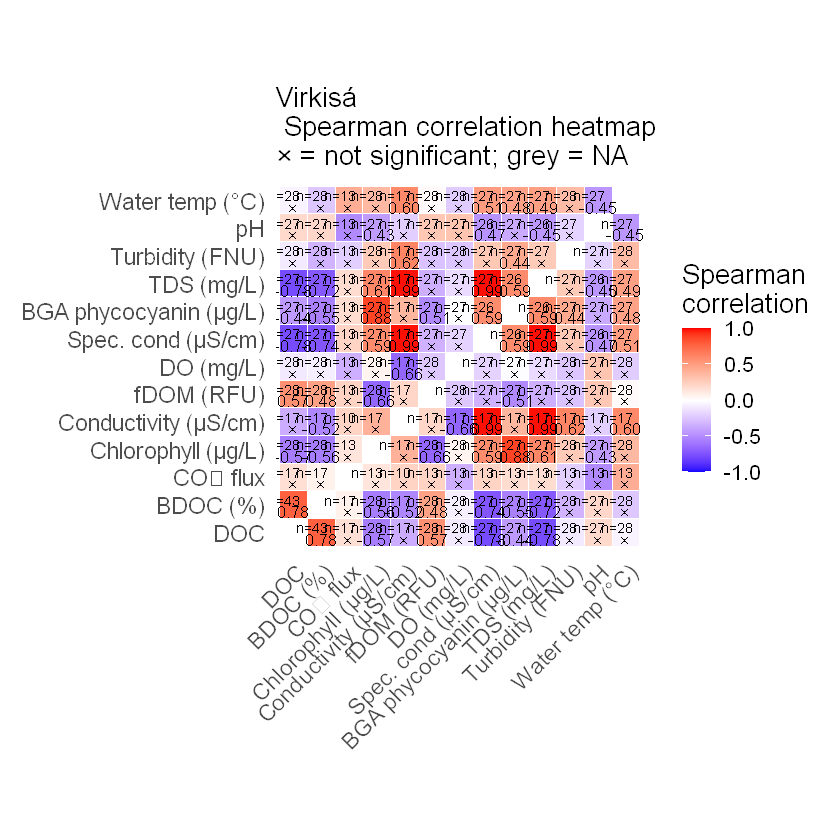

In [75]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(Hmisc)
  library(reshape2); library(ggplot2); library(tidyr); library(tools)
})

# ========= 🔧 EDIT AREA =========
corr_type    <- "spearman"   # or "spearman"
group_filter <- "all"           # 1 = nur group_nr 1; "all" = alle; z.B. 2 = nur group_nr 2

# Carbon (fix)
carbon_vars <- c("average_DOC_sample", "BDOC_pct", "CO2_Flux")

# Environmental (dein Set)
env_vars <- c(
  "Chlorophyll_ugperL", "Cond_uSpercm_korr", "fDOM_RFU",
  "ODO_mgperL", "SpCond_uSpercm_korr", "BGA_PC_ugperL",
  "TDS_mgperL_korr", "Turbidity_FNU", "pH", "Temp_C"
)

# Achsenreihenfolge: erst Carbon, dann Environmental
vars_keep <- c(carbon_vars, env_vars)

# Englische Labels
rename_map <- c(
  average_DOC_sample       = "DOC",
  BDOC_pct                 = "BDOC (%)",
  CO2_Flux                 = "CO₂ flux",
  Chlorophyll_ugperL       = "Chlorophyll (µg/L)",
  Cond_uSpercm_korr        = "Conductivity (µS/cm)",
  fDOM_RFU                 = "fDOM (RFU)",
  ODO_mgperL               = "DO (mg/L)",
  SpCond_uSpercm_korr      = "Spec. cond (µS/cm)",
  BGA_PC_ugperL            = "BGA phycocyanin (µg/L)",
  TDS_mgperL_korr          = "TDS (mg/L)",
  Turbidity_FNU            = "Turbidity (FNU)",
  pH                       = "pH",
  Temp_C                   = "Water temp (°C)"
)

# Farben
col_low <- "blue"; col_mid <- "white"; col_high <- "red"
# ===================================

# 📁 File
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(file_path)

# ✅ Gruppen-Filter
if (!identical(group_filter, "all")) {
  df <- df %>% filter(group_nr == group_filter)
}

# 🔧 gewünschte Spalten zu numeric parsen (Komma → Punkt)
to_num_cols <- intersect(vars_keep, names(df))
df <- df %>%
  mutate(across(all_of(to_num_cols), ~{
    v <- .
    if (is.numeric(v)) return(v)
    v_chr <- as.character(v)
    v_chr[v_chr %in% c("", "NA")] <- NA
    suppressWarnings(as.numeric(gsub(",", ".", v_chr)))
  }))

# 📂 Output
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

pretty_name <- function(river_id) ifelse(river_id == "Virkisa", "Virkisá", "Vestari-Jökulsá")

make_plot_env <- function(river_id) {
  df_river <- df %>% filter(river_name == river_id)

  # nur gewünschte Spalten, Reihenfolge respektieren
  d0 <- df_river %>% select(any_of(vars_keep))

  # Spalten mit n<3 oder sd==0 entfernen; Zeilen mit nur NAs raus
  d <- d0 %>%
    filter(rowSums(is.na(.)) < ncol(.)) %>%
    select(where(function(x){ vx <- x[!is.na(x)]; length(vx) >= 3 && sd(vx) != 0 }))

  if (ncol(d) < 2) stop(paste("Not enough valid variables after filtering for", river_id))

  co <- rcorr(as.matrix(d), type = corr_type)
  r_df <- reshape2::melt(co$r, na.rm = FALSE)
  p_df <- reshape2::melt(co$P, na.rm = FALSE)
  n_df <- reshape2::melt(co$n, na.rm = FALSE)
  colnames(r_df) <- c("Var1","Var2","Correlation")
  colnames(p_df) <- c("Var1","Var2","Pvalue")
  colnames(n_df) <- c("Var1","Var2","Npair")

  plot_df <- r_df %>%
    left_join(p_df, by=c("Var1","Var2")) %>%
    left_join(n_df, by=c("Var1","Var2")) %>%
    filter(as.character(Var1) != as.character(Var2))

  # Labels
  label_map <- setNames(names(d), names(d))
  label_map[names(rename_map)] <- rename_map[names(rename_map) %in% names(label_map)]

  plot_df <- plot_df %>%
    mutate(
      Var1_lab = dplyr::recode(as.character(Var1), !!!label_map, .default = as.character(Var1)),
      Var2_lab = dplyr::recode(as.character(Var2), !!!label_map, .default = as.character(Var2)),
      Significant = Pvalue < 0.05,
      Label = dplyr::case_when(
        is.na(Correlation) ~ "n<3",
        Significant        ~ sprintf("%.2f", Correlation),
        TRUE               ~ "\u00D7"
      ),
      Nlab = ifelse(is.na(Npair), "", paste0("n=", Npair))
    )

  axis_order_lab <- unname(label_map[colnames(d)])
  plot_df$Var1_lab <- factor(plot_df$Var1_lab, levels = axis_order_lab)
  plot_df$Var2_lab <- factor(plot_df$Var2_lab, levels = axis_order_lab)

  # Plot
  leg_name    <- paste(toTitleCase(corr_type), "\ncorrelation")
  group_label <- ifelse(identical(group_filter, "all"),
                        "all groups",
                        paste0("group_nr=", group_filter))

  p <- ggplot(plot_df, aes(Var1_lab, Var2_lab, fill = Correlation)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Label), size = 3.5, fontface = "plain", vjust = 1) +
    geom_text(aes(label = Nlab), size = 3,
              hjust = 1.1, vjust = 1, nudge_x = 0.38, nudge_y = 0.38) +
    scale_fill_gradient2(low = col_low, mid = col_mid, high = col_high,
                         midpoint = 0, limits = c(-1, 1),
                         name = leg_name, na.value = "grey90") +
    coord_fixed() +
    theme_minimal(base_size = 16) +
    theme(
      axis.text.x = element_text(size = 14, angle = 45, vjust = 1, hjust = 1),
      axis.text.y = element_text(size = 14),
      axis.title  = element_blank(),
      panel.grid  = element_blank(),
      plot.title  = element_text(size = 16, face = "plain")
    ) +
    labs(title = paste0(pretty_name(river_id), "\n ", toTitleCase(corr_type),
                        " correlation heatmap \n× = not significant; grey = NA"))

  outfile <- file.path(
    out_dir,
    paste0("Heatmap_", river_id, "_Env_", gsub("[ =]", "_", group_label), "_",
           toTitleCase(corr_type), "_NAaware_Signif_English.png")
  )
  ggsave(outfile, plot = p, width = 10, height = 10, dpi = 300)
  message("✅ Saved: ", outfile)
  print(p)
}

# 🚀 Beide Flüsse
make_plot_env("Vestari_Joekulsa")
make_plot_env("Virkisa")


# fluo

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Vestari_Joekulsa_Fluo_all_groups_Spearman_NAaware_Signif_English.png

✅ Saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Heatmap_Virkisa_Fluo_all_groups_Spearman_NAaware_Signif_English.png



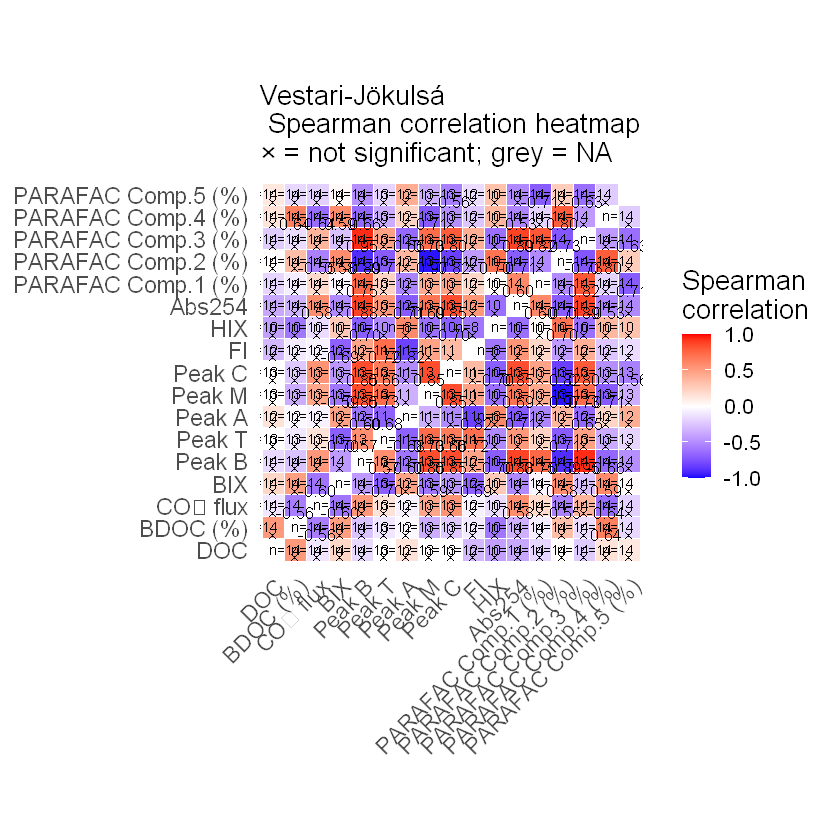

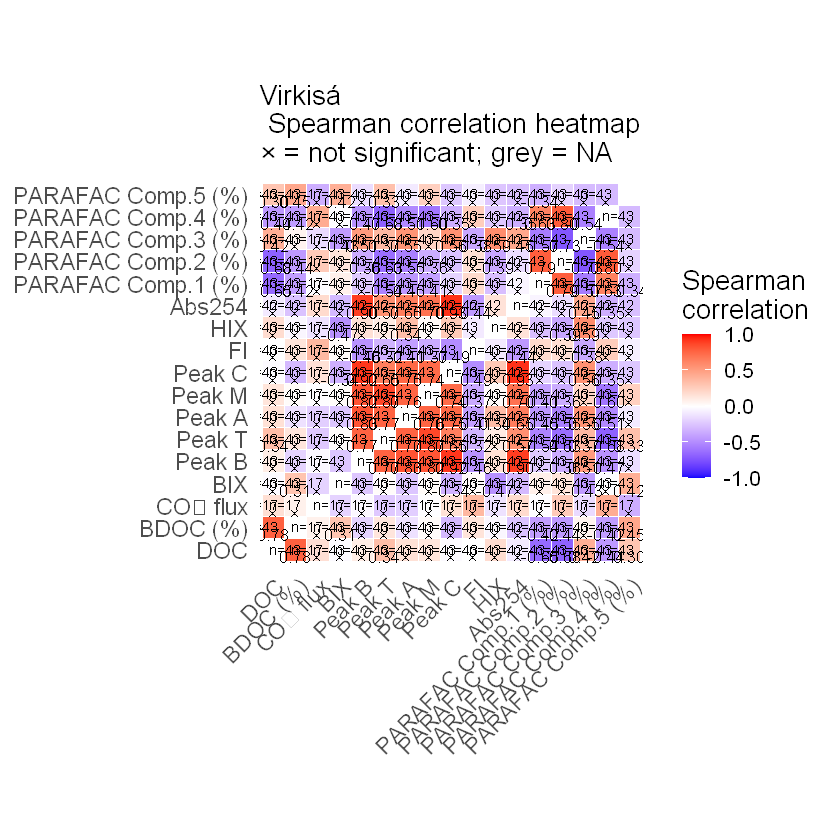

In [74]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(Hmisc)
  library(reshape2); library(ggplot2); library(tidyr); library(tools)
})

# ========= 🔧 EDIT AREA =========
corr_type   <- "spearman"    # or "spearman"
group_filter <- "all"           # 1 = nur group_nr 1; "all" = alle Gruppen; z.B. 2 = nur group_nr 2

# Carbon (fix)
carbon_vars <- c("average_DOC_sample", "BDOC_pct", "CO2_Flux")

# Fluorescence (dein Set)
fluo_vars <- c(
  "bix", "b", "t", "a", "m", "c", "fi", "hix", "a254",
  "pctComp.1", "pctComp.2", "pctComp.3", "pctComp.4", "pctComp.5"
)

# Achsen: erst Carbon, dann Fluorescence
vars_keep <- c(carbon_vars, fluo_vars)

# Labels
rename_map <- c(
  average_DOC_sample = "DOC",
  BDOC_pct           = "BDOC (%)",
  CO2_Flux           = "CO₂ flux",
  bix                = "BIX",
  b                  = "Peak B",
  t                  = "Peak T",
  a                  = "Peak A",
  m                  = "Peak M",
  c                  = "Peak C",
  fi                 = "FI",
  hix                = "HIX",
  a254               = "Abs254",
  pctComp.1          = "PARAFAC Comp.1 (%)",
  pctComp.2          = "PARAFAC Comp.2 (%)",
  pctComp.3          = "PARAFAC Comp.3 (%)",
  pctComp.4          = "PARAFAC Comp.4 (%)",
  pctComp.5          = "PARAFAC Comp.5 (%)"
)

col_low  <- "blue"; col_mid  <- "white"; col_high <- "red"
# ===================================

# 📁 File
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA.xlsx"
df <- read_excel(file_path)

# ✅ Gruppen-Filter anwenden
if (!identical(group_filter, "all")) {
  df <- df %>% filter(group_nr == group_filter)
}

# 🔧 gewünschte Spalten numerisch parsen
to_num_cols <- intersect(vars_keep, names(df))
df <- df %>%
  mutate(across(all_of(to_num_cols), ~{
    v <- .
    if (is.numeric(v)) return(v)
    v_chr <- as.character(v)
    v_chr[v_chr %in% c("", "NA")] <- NA
    suppressWarnings(as.numeric(gsub(",", ".", v_chr)))
  }))

# 📂 Output
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

pretty_name <- function(river_id) ifelse(river_id == "Virkisa", "Virkisá", "Vestari-Jökulsá")

make_plot_fluo <- function(river_id) {
  df_river <- df %>% filter(river_name == river_id)

  d0 <- df_river %>% select(any_of(vars_keep))
  d <- d0 %>%
    filter(rowSums(is.na(.)) < ncol(.)) %>%
    select(where(function(x){ vx <- x[!is.na(x)]; length(vx) >= 3 && sd(vx) != 0 }))

  if (ncol(d) < 2) stop(paste("Not enough valid variables after filtering for", river_id))

  co <- rcorr(as.matrix(d), type = corr_type)
  r_df <- reshape2::melt(co$r, na.rm = FALSE)
  p_df <- reshape2::melt(co$P, na.rm = FALSE)
  n_df <- reshape2::melt(co$n, na.rm = FALSE)
  colnames(r_df) <- c("Var1","Var2","Correlation")
  colnames(p_df) <- c("Var1","Var2","Pvalue")
  colnames(n_df) <- c("Var1","Var2","Npair")

  plot_df <- r_df %>%
    left_join(p_df, by=c("Var1","Var2")) %>%
    left_join(n_df, by=c("Var1","Var2")) %>%
    filter(as.character(Var1) != as.character(Var2))

  # Labels
  label_map <- setNames(names(d), names(d))
  label_map[names(rename_map)] <- rename_map[names(rename_map) %in% names(label_map)]

  plot_df <- plot_df %>%
    mutate(
      Var1_lab = dplyr::recode(as.character(Var1), !!!label_map, .default = as.character(Var1)),
      Var2_lab = dplyr::recode(as.character(Var2), !!!label_map, .default = as.character(Var2)),
      Significant = Pvalue < 0.05,
      Label = dplyr::case_when(
        is.na(Correlation) ~ "n<3",
        Significant        ~ sprintf("%.2f", Correlation),
        TRUE               ~ "\u00D7"
      ),
      Nlab = ifelse(is.na(Npair), "", paste0("n=", Npair))
    )

  axis_order_lab <- unname(label_map[colnames(d)])
  plot_df$Var1_lab <- factor(plot_df$Var1_lab, levels = axis_order_lab)
  plot_df$Var2_lab <- factor(plot_df$Var2_lab, levels = axis_order_lab)

  # Plot
  leg_name <- paste(toTitleCase(corr_type), "\ncorrelation")
  group_label <- ifelse(identical(group_filter, "all"),
                        "all groups",
                        paste("group_nr=", group_filter))
  p <- ggplot(plot_df, aes(Var1_lab, Var2_lab, fill = Correlation)) +
    geom_tile(color = "white") +

    
    geom_text(aes(label = Label), size = 3.5, fontface = "plain", vjust = 1) +
    geom_text(aes(label = Nlab), size = 3,
          hjust = 1.1, vjust = 1.3, nudge_x = 0.38, nudge_y = 0.45) +

    
    scale_fill_gradient2(low = col_low, mid = col_mid, high = col_high,
                         midpoint = 0, limits = c(-1, 1),
                         name = leg_name, na.value = "grey90") +
    coord_fixed() +
    theme_minimal(base_size = 16) +
    theme(
      axis.text.x = element_text(size = 14, angle = 45, vjust = 1, hjust = 1),
      axis.text.y = element_text(size = 14),
      axis.title  = element_blank(),
      panel.grid  = element_blank(),
      plot.title  = element_text(size = 16, face = "plain")
    ) +
    labs(title = paste0(pretty_name(river_id), "\n ", toTitleCase(corr_type),
                        " correlation heatmap \n× = not significant; grey = NA"))

  outfile <- file.path(out_dir, paste0("Heatmap_", river_id, "_Fluo_", group_label, "_",
                                       toTitleCase(corr_type), "_NAaware_Signif_English.png"))
  # Leerzeichen und = im Dateinamen durch _ ersetzen
  outfile <- gsub("[ =]", "_", outfile)
  ggsave(outfile, plot = p, width = 10, height = 10, dpi = 300)
  message("✅ Saved: ", outfile)
  print(p)
}

# 🚀 Beide Flüsse
make_plot_fluo("Vestari_Joekulsa")
make_plot_fluo("Virkisa")


# Table


In [73]:
# 📦 Packages
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr)
  library(purrr);  library(tibble); library(openxlsx)
  library(knitr)
})

# ==== Paths ====
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
in_file  <- file.path(base_dir, "Sophia_Data.xls")
out_dir  <- file.path(base_dir, "Ergebnisse_HM_Wetter", "Tabellen")
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ==== Load data ====
dat <- read_excel(in_file)

# ==== Variable groups ====
carbon_vars <- c(
  "average_DOC_sample" = "DOC (mg/L)",
  "BDOC_pct"           = "BDOC (%)",
  "CO2_Flux"           = "CO₂ flux"
)

weather_vars <- c(
  "Air_temp"                    = "Air temp (°C)",
  "Max_temp"                    = "Max temp (°C)",
  "Min_temp"                    = "Min temp (°C)",
  "Wind_direction_deg"          = "Wind direction (°)",
  "Wind_speed_mpers"            = "Wind speed (m/s)",
  "Max_av_wind_speed_mpers"     = "Max avg wind (m/s)",
  "Max_wind_gust_mpers"         = "Max gust (m/s)",
  "Precipitation_in_past_hour_mm" = "Precipitation (mm)"
)

env_vars <- c(
  "Chlorophyll_ugperL"   = "Chlorophyll (µg/L)",
  "Cond_uSpercm_korr"    = "Conductivity (µS/cm)",
  "fDOM_RFU"             = "fDOM (RFU)",
  "ODO_mgperL"           = "Dissolved O₂ (mg/L)",
  "SpCond_uSpercm_korr"  = "Specific Conductivity (µS/cm)",
  "BGA_PC_ugperL"        = "Phycocyanin (µg/L)",
  "TDS_mgperL_korr"      = "TDS (mg/L)",
  "Turbidity_FNU"        = "Turbidity (FNU)",
  "pH"                   = "pH (-)",
  "Temp_C"               = "Water temp (°C)"
)

fluo_vars <- c(
  "bix"       = "BIX",
  "b"         = "PARAFAC b",
  "t"         = "PARAFAC t",
  "a"         = "PARAFAC a",
  "m"         = "PARAFAC m",
  "c"         = "PARAFAC c",
  "fi"        = "FI",
  "hix"       = "HIX",
  "a254"      = "Absorbance at 254 nm",
  "pctComp.1" = "Component 1 (%)",
  "pctComp.2" = "Component 2 (%)",
  "pctComp.3" = "Component 3 (%)",
  "pctComp.4" = "Component 4 (%)",
  "pctComp.5" = "Component 5 (%)"
)

# ==== Safe numeric conversion ====
as_numeric_safely <- function(x) {
  if (is.numeric(x)) return(x)
  if (is.factor(x))  x <- as.character(x)
  if (is.character(x)) {
    x <- trimws(x)
    x <- gsub("\\.", "", x)              # remove thousands separator
    x <- gsub(",", ".", x, fixed = TRUE) # convert , to .
  }
  suppressWarnings(as.numeric(x))
}

# ==== Shapiro & correlation choice ====
one_var_stats <- function(vec) {
  x <- vec[!is.na(vec)]
  n <- length(x)
  if (n >= 3 && n <= 5000) {
    sh <- try(shapiro.test(x), silent = TRUE)
    if (inherits(sh, "try-error")) {
      list(n = n, W = NA_real_, p = NA_real_, normal = "error", test = "not available")
    } else {
      pval <- sh$p.value
      normal <- ifelse(pval > 0.05, "yes", "no")
      test   <- ifelse(pval > 0.05, "Pearson", "Spearman")
      list(n = n, W = unname(sh$statistic), p = pval, normal = normal, test = test)
    }
  } else if (n > 5000) {
    list(n = n, W = NA_real_, p = NA_real_, normal = "n > 5000 (Shapiro not valid)", test = "Pearson (large n)")
  } else {
    list(n = n, W = NA_real_, p = NA_real_, normal = "too few data", test = "not available")
  }
}

make_table <- function(df, named_vars) {
  map_dfr(names(named_vars), function(v) {
    x_raw <- df[[v]]
    x_num <- as_numeric_safely(x_raw)
    stats <- one_var_stats(x_num)
    tibble(
      Variable          = v,
      Label             = unname(named_vars[v]),
      n_obs             = stats$n,
      Shapiro_W         = if (!is.na(stats$W)) round(stats$W, 3) else NA_real_,
      Shapiro_p         = if (!is.na(stats$p)) signif(stats$p, 3) else NA_real_,
      Normality         = stats$normal,
      Suggested_test    = stats$test
    )
  })
}

# ==== Create tables ====
tab_carbon  <- make_table(dat, carbon_vars)
tab_weather <- make_table(dat, weather_vars)
tab_env     <- make_table(dat, env_vars)
tab_fluo    <- make_table(dat, fluo_vars)

# ==== Show nicely in Jupyter (ASCII tables, no HTML) ====
cat("\n=== CARBON ===\n")
print(kable(tab_carbon, format = "simple"))

cat("\n=== WEATHER ===\n")
print(kable(tab_weather, format = "simple"))

cat("\n=== ENVIRONMENT ===\n")
print(kable(tab_env, format = "simple"))

cat("\n=== FLUORESCENCE ===\n")
print(kable(tab_fluo, format = "simple"))

# ==== Save as Excel ====
write.xlsx(tab_carbon,  file.path(out_dir, "Carbon_Table.xlsx"))
write.xlsx(tab_weather, file.path(out_dir, "Weather_Table.xlsx"))
write.xlsx(tab_env,     file.path(out_dir, "Environment_Table.xlsx"))
write.xlsx(tab_fluo,    file.path(out_dir, "Fluo_Table.xlsx"))



=== CARBON ===


Variable             Label         n_obs   Shapiro_W   Shapiro_p  Normality   Suggested_test 
-------------------  -----------  ------  ----------  ----------  ----------  ---------------
average_DOC_sample   DOC (mg/L)       57       0.868    1.63e-05  no          Spearman       
BDOC_pct             BDOC (%)         57       0.963    7.72e-02  yes         Pearson        
CO2_Flux             CO₂ flux         31       0.902    7.99e-03  no          Spearman       

=== WEATHER ===


Variable                        Label                 n_obs   Shapiro_W   Shapiro_p  Normality   Suggested_test 
------------------------------  -------------------  ------  ----------  ----------  ----------  ---------------
Air_temp                        Air temp (°C)            57       0.963    7.64e-02  yes         Pearson        
Max_temp                        Max temp (°C)            57       0.964    8.64e-02  yes         Pearson        
Min_temp                        Min temp 

Warning message in file.create(to[okay]):
"kann Datei 'C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Tabellen/Environment_Table.xlsx' nicht erzeugen. Grund 'Permission denied'"
Warning message in file.create(to[okay]):
"kann Datei 'C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_HM_Wetter/Tabellen/Fluo_Table.xlsx' nicht erzeugen. Grund 'Permission denied'"
